<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-подключение-библиотек" data-toc-modified-id="Загрузка-данных-и-подключение-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных и подключение библиотек</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Расположение-данных-в-хронологическом-порядке" data-toc-modified-id="Расположение-данных-в-хронологическом-порядке-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Расположение данных в хронологическом порядке</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Временной-ряд-и-скользящее-среднее" data-toc-modified-id="Временной-ряд-и-скользящее-среднее-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Временной ряд и скользящее среднее</a></span></li><li><span><a href="#Тренд-временного-ряда" data-toc-modified-id="Тренд-временного-ряда-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Тренд временного ряда</a></span></li><li><span><a href="#Сезонность-временного-ряда" data-toc-modified-id="Сезонность-временного-ряда-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Сезонность временного ряда</a></span></li><li><span><a href="#Остатки-временного-ряда" data-toc-modified-id="Остатки-временного-ряда-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Остатки временного ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Загрузка данных и подключение библиотек

In [1]:
!pip install --upgrade scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from math import ceil
from sklearn.model_selection import (train_test_split, 
                                     RandomizedSearchCV, 
                                     TimeSeriesSplit)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   OrdinalEncoder
                                  )
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

In [4]:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [5]:
# Предварительный обзор данных
def data_overview(reviewed_dataframe):
    print('=' * 125)
    print('Общая информация о датафрейме:\n')
    print(reviewed_dataframe.info())
    print('*' * 125)
    print('Статистическое описание числовых параметров датафрейма:\n')
    print(reviewed_dataframe.describe())
    print('*' * 125)
    print('Датафрейм:\n')
    print(reviewed_dataframe.head())

In [6]:
data_overview(taxi)

Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
*****************************************************************************************************************************
Статистическое описание числовых параметров датафрейма:

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000
*****************************************************************************************************************************
Датафрейм:

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
20

Пропуски в данных отсутствуют. 

## Подготовка данных

### Расположение данных в хронологическом порядке

In [7]:
# Расположим данные в хронологическом порядке
taxi.sort_index(inplace=True)

# Проверка
taxi.index.is_monotonic

True

### Ресемплирование

In [8]:
# Проведем ресемплирование по одному часу
taxi = taxi.resample('1H').sum()

# Проверка
taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Анализ

### Временной ряд и скользящее среднее

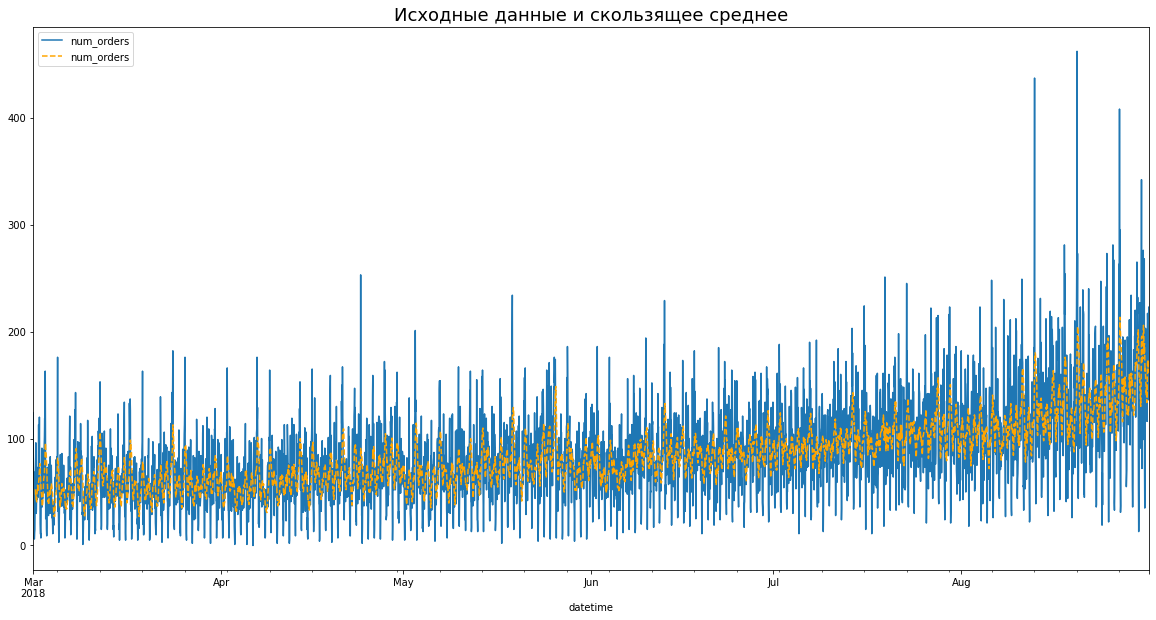

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Построение графика исходных данных
taxi.plot(ax=ax, label='Исходные данные')

# Построение графика скользящего среднего
taxi.rolling(10).mean().plot(ax=ax, label='Скользящее среднее', linestyle='--', color='orange')

ax.set_title('Исходные данные и скользящее среднее', fontsize=18)
ax.legend()

plt.show()

In [10]:
decomposed = seasonal_decompose(taxi) 

In [11]:
# Построение графиков тренда, сезонности и остатков
def plot_decomposition(component, title, ylabel):
    plt.figure(figsize=(20, 10))  
    component.plot(ax=plt.gca())  
    plt.title(title, fontsize=18)  
    plt.xlabel('Дата')  
    plt.ylabel(ylabel) 
    plt.show()  

### Тренд временного ряда

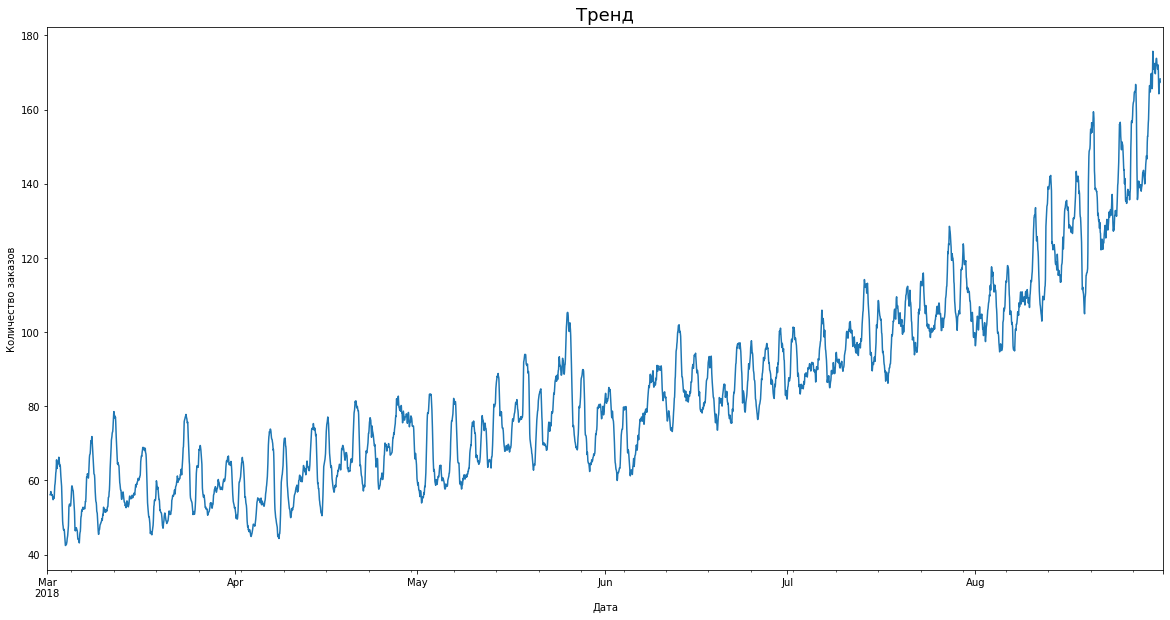

In [12]:
plot_decomposition(decomposed.trend, 'Тренд', 'Количество заказов')

### Сезонность временного ряда

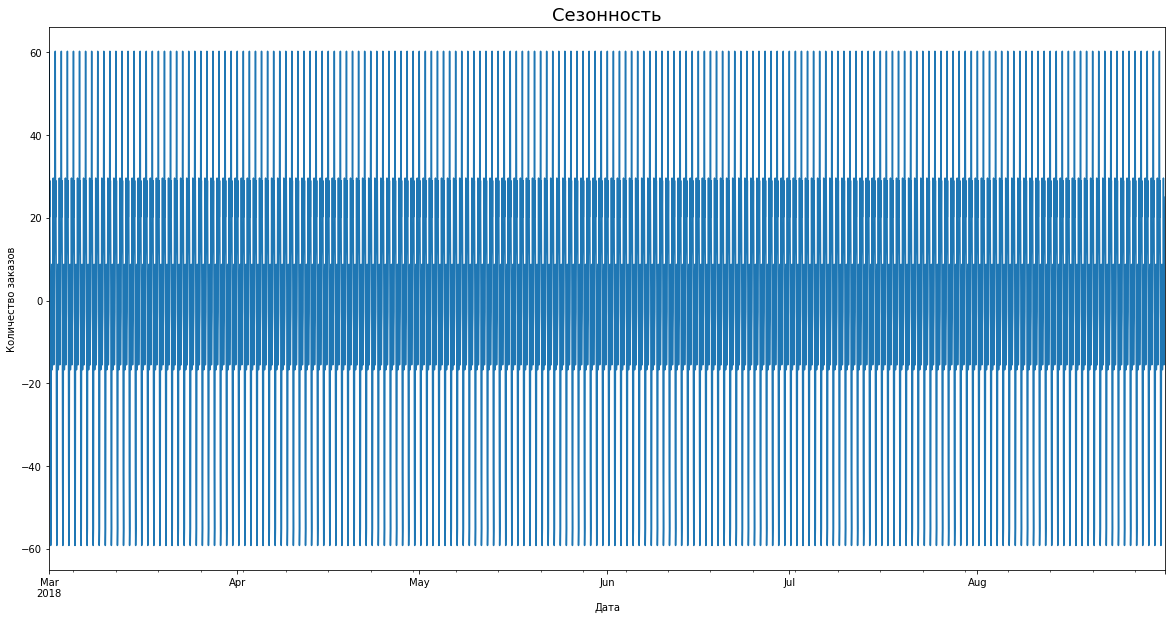

In [13]:
plot_decomposition(decomposed.seasonal, 'Сезонность', 'Количество заказов')

### Остатки временного ряда

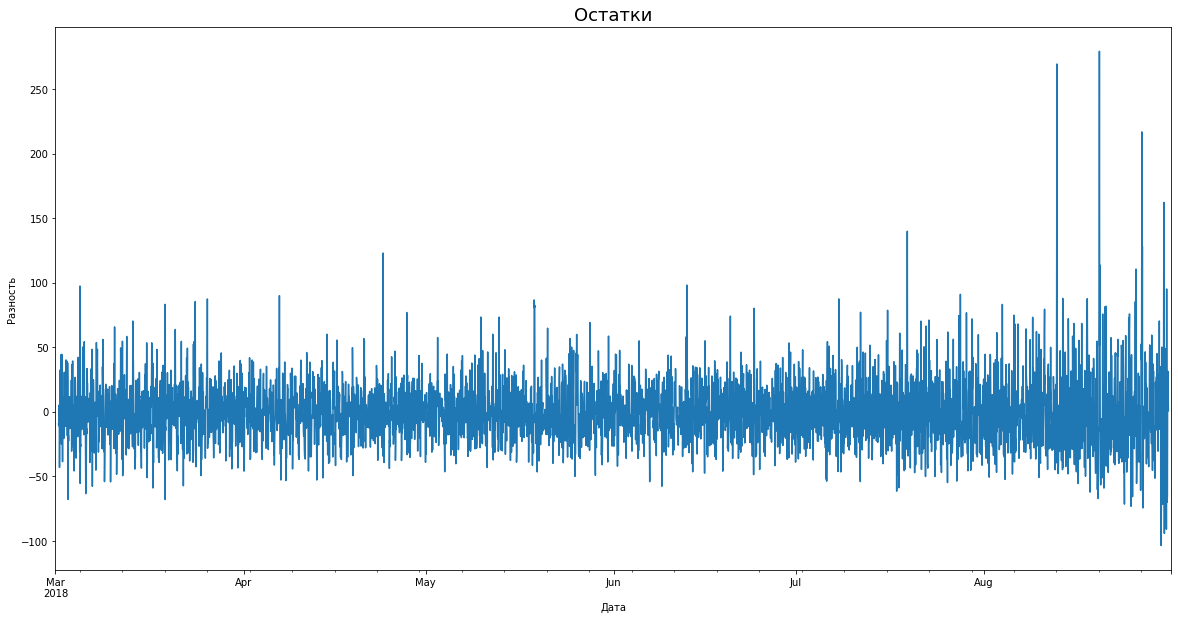

In [14]:
plot_decomposition(decomposed.resid, 'Остатки', 'Разность')

Опираясь на график временного ряда и график тренда, можно отметить, увеличение среднего количества заказов такси, начиная с апреля месяца. Это может быть связано с улучшением погодных условий, которые влекут за собой у людей желание выйти из дома и куда-нибудь слетать, в некоторых компаниях часто на апрель-май выпадают важные командировки сотрудников, а в июне начинается сезон отпусков, и все это влечет за собой необходимость как добраться до аэропорта, так и уехать из него. Наблюдается некоторая сезонная составляющая, касающаяся краткосрочных временных интервалов в течение месяца (возможно, присутсвует некоторая сезонность в каждый день месяца) и "наложенная" на общий рост. График сезонности демонстрирует регулярные колебания, которые повторяются с постоянной амплитудой в 60 заказов. На графике остатков большая часть значение колеблется около 0, в общем значения варьируются от -100 до 250. Среди них наблюдаются некоторые "внезапные" значения, особенно в конце графика шумов. Внезапный рост количества заказов такси может быть связан с появлением каких-либо неожиданных факторов, влияющих на количество заказов. Например, внезапный рост количества заказов такси может быть обусловлен тем, что в какую-то дату действовал промокод на поездку, были проблемы с общественным транспортом и т.д.

Проведем более детальный для краткосрочных временных интервалов. Посмотрим:
- сезонность для 7 дней каждого месяца (недельный интервал)

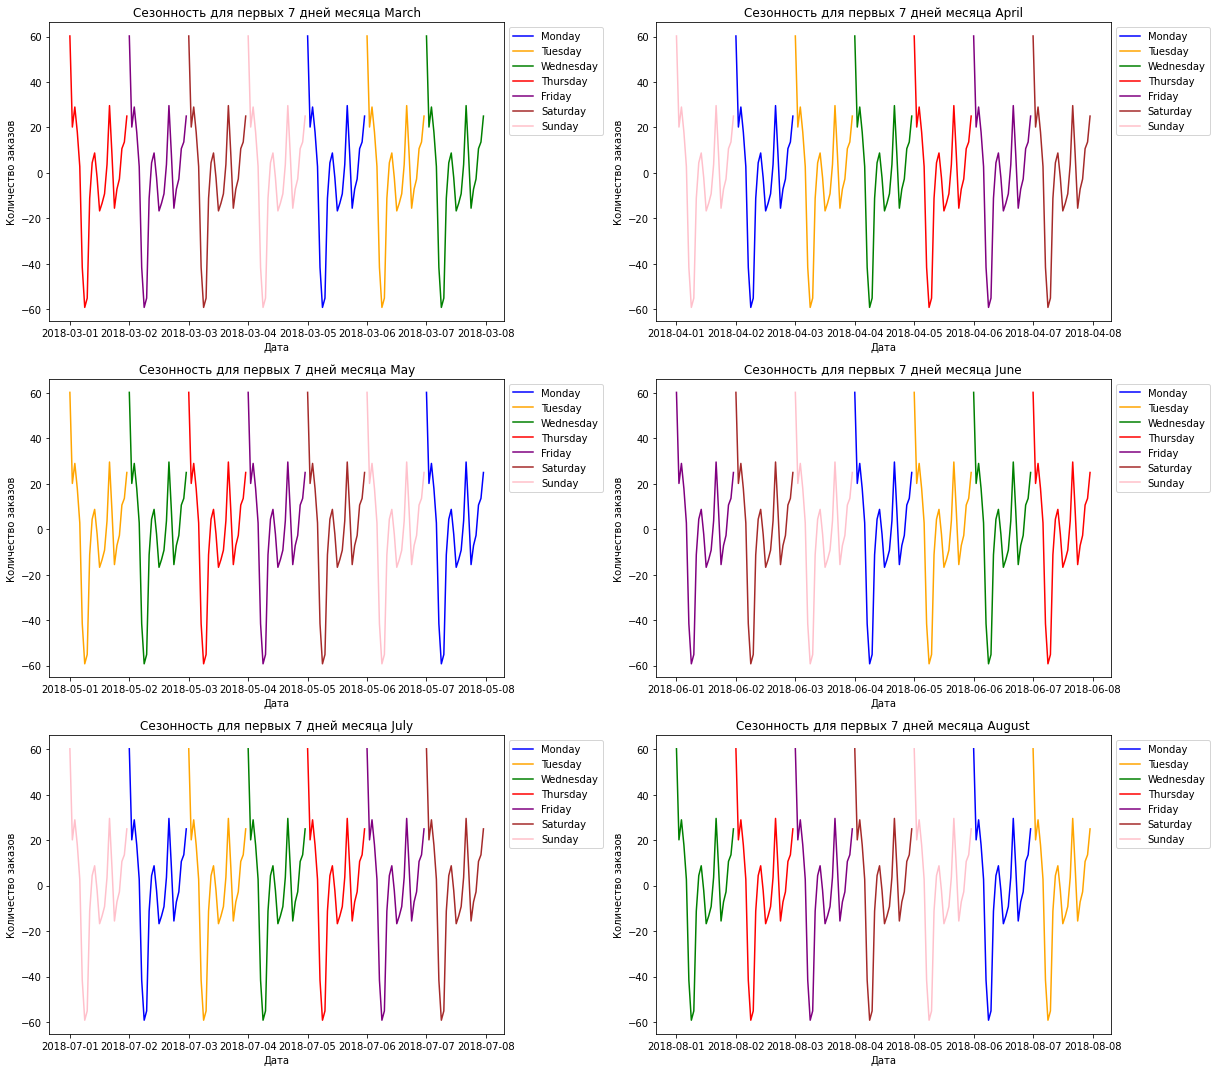

In [15]:
# сезонность для 7 дней каждого месяца (недельный интервал)
unique_months = taxi.index.month.unique()

fig, axs = plt.subplots(ceil(len(unique_months) / 2), 2, figsize=(20, 15))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

for index, month in enumerate(unique_months):
    row = index // 2
    col = index % 2

    seasonal_data = decomposed.seasonal[(taxi.index.month == month) & (taxi.index.day <= 7)]
    
    for day in range(7):
        day_data = seasonal_data[seasonal_data.index.dayofweek == day]
        axs[row][col].plot(day_data.index, day_data, label=calendar.day_name[day], color=colors[day])
    
    axs[row][col].set_title(f'Сезонность для первых 7 дней месяца {calendar.month_name[month]}')
    axs[row][col].set_xlabel('Дата')
    axs[row][col].set_ylabel('Количество заказов')
    axs[row][col].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()

Можем заметить, что каждому дню недели соответствует одинаковая сезонность - есть три пиковые точки с повышенным колчеством заказов за час, они приходятся на утренние, обеденные и ночные часы. Рассмотрим сезонность для одно рандомного дня рандомного месяца.

- сезонность для одно рандомного дня рандомного месяца

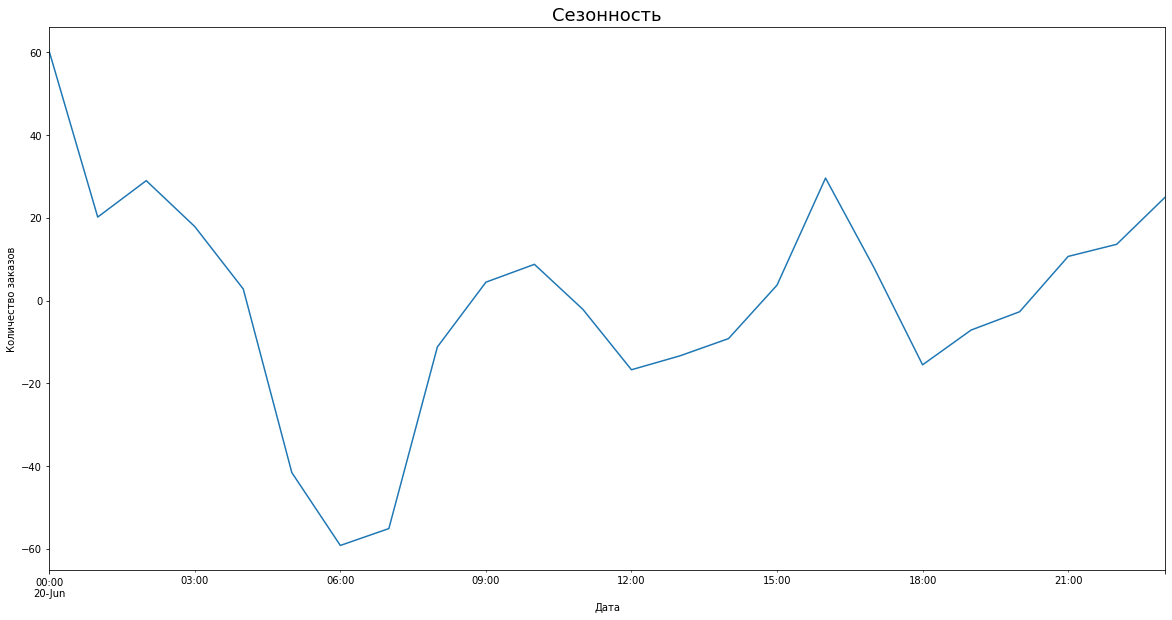

In [16]:
random_month = np.random.choice(taxi.index.month.unique())
random_day = np.random.choice(taxi.index.day.unique())

plot_decomposition(decomposed.seasonal[(taxi.index.month == random_month) & (taxi.index.day == random_day)], 'Сезонность', 'Количество заказов')

Наибольшее количество заказов приходится на полночь - около 60 заказов за 1 час.  Это можно объяснить тем , что люди хотят добраться до дома комфортно и быстро, особенно в поздний час, когда такие прилагательные не могут быть применимы к общественному транспорту. Далее число заказов идет на спад и в интервале с 6:00-7:00 оно минимально. Также пики приходятся на 9:00-11:00 утра, когда такси, наиболее вероятно довозит людей, которым необходимо успеть на работу и по другим важным делам сразу после аэропорта, и на 16:00 - причины могут быть аналогичны любым из перечисленных.

## Обучение

### Создание признаков

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['hour'] = data_new.index.hour
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_' + str(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    
    return data_new

In [18]:
taxi_new = make_features(taxi, 24, 10)

taxi_new.head(15)

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,5,3,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,6,3,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,1,7,3,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,1,8,3,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
taxi_new = taxi_new.dropna()

# Проверка
taxi_new.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,0,4,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,61.7
2018-03-02 01:00:00,120,3,2,1,4,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.9
2018-03-02 02:00:00,75,3,2,2,4,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,71.3
2018-03-02 03:00:00,64,3,2,3,4,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,74.5
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,76.5


In [20]:
X = taxi_new.drop('num_orders', axis=1)
y = taxi_new['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=False,
                                                    test_size=0.1)

### Обучение моделей

In [21]:
num_col_names = X_train.columns

num_col_names

Index(['month', 'day', 'hour', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object')

In [22]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('num', MinMaxScaler(), num_col_names)
    ], 
    remainder='passthrough'
)

In [23]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [24]:
param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели SVR()
    {
        'models': [SVR()],
        'models__kernel' : ['rbf','sigmoid', 'linear', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, objective='regression', metric='rmse')],
        'models__max_depth': range(1, 5),  
        'models__learning_rate': [0.01, 0.1, 1.0],
    } 
]

In [25]:
tscv = TimeSeriesSplit(n_splits=5)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [26]:
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели, полученная при кросс-валидации:', abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['month', 'day', 'hour', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object'))])),
                ('models',
                 LGBMRegressor(max_depth=2, metric='rmse',
                               objective='regression', random_state=42))])
Метрика лучшей модели, полученная при кросс-валидации: 25.420168806944055


## Тестирование

In [27]:
best_model = randomized_search.best_estimator_
pred = best_model.predict(X_test)
print(f'RMSE на тестовой выборке: {root_mean_squared_error(y_test, pred)}')

RMSE на тестовой выборке: 43.39676735223156


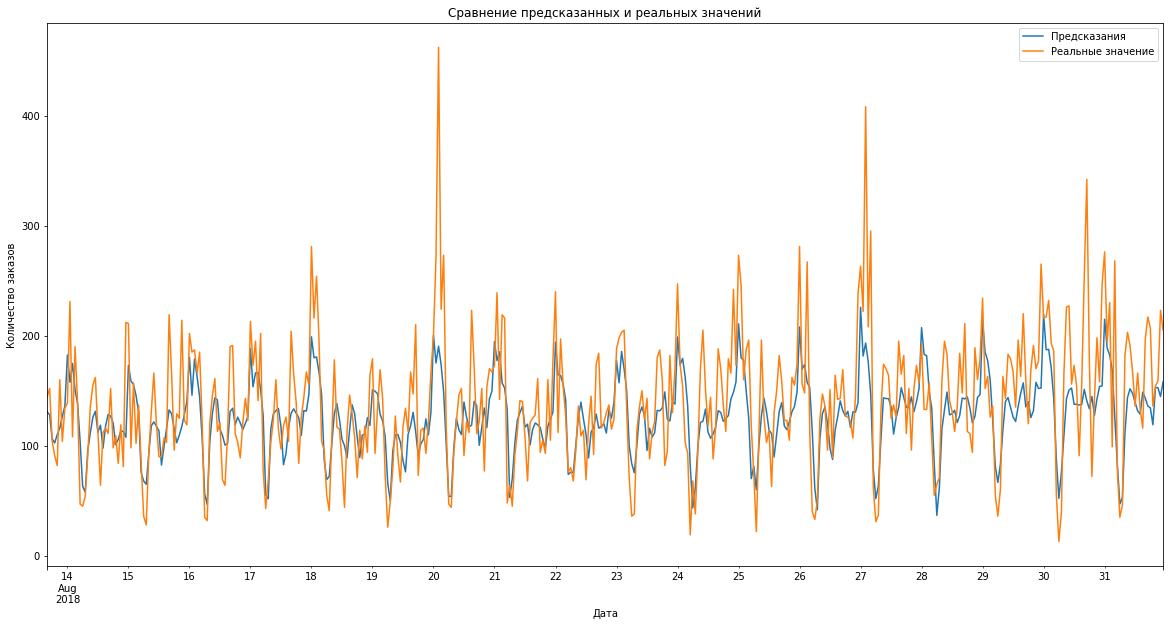

In [28]:
# Визуализируем предсказанные результаты и сравним их с реальными значениями
y_pred = pd.Series(pred, index=y_test.index, name='Предсказания')
real = pd.Series(y_test, name='Реальные значение')

df = pd.concat([y_pred, real], axis=1)

df.plot(figsize=(20, 10))

plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.show()

## Общий вывод

Перед нами стояла задача спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

В ходе анализа графика временного ряда, его тренда, сезонности и остатков было отмечено увеличение среднего количества заказов такси, начиная с апреля месяца. Это может быть связано с улучшением погодных условий, которые влекут за собой у людей желание выйти из дома и куда-нибудь слетать, в некоторых компаниях часто на апрель-май выпадают важные командировки сотрудников, а в июне начинается сезон отпусков, и все это влечет за собой необходимость как добраться до аэропорта, так и уехать из него. Наблюдается некоторая сезонная составляющая, касающаяся краткосрочных временных интервалов в течение месяца (возможно, присутсвует некоторая сезонность в каждый день месяца) и "наложенная" на общий рост. График сезонности демонстрирует регулярные колебания, которые повторяются с постоянной амплитудой в 60 заказов. На графике остатков большая часть значение колеблется около 0, в общем значения варьируются от -100 до 250. Среди них наблюдаются некоторые "внезапные" значения, особенно в конце графика шумов. Внезапный рост количества заказов такси может быть связан с появлением каких-либо неожиданных факторов, влияющих на количество заказов. Например, внезапный рост количества заказов такси может быть обусловлен тем, что в какую-то дату действовал промокод на поездку, были проблемы с общественным транспортом и т.д. Наибольшее количество заказов приходится на полночь - около 60 заказов за 1 час. Это можно объяснить тем , что люди хотят добраться до дома комфортно и быстро, особенно в поздний час, когда такие прилагательные не могут быть применимы к общественному транспорту. Далее число заказов идет на спад и в интервале с 6:00-7:00 оно минимально. Также пики приходятся на 9:00-11:00 утра, когда такси, наиболее вероятно довозит людей, которым необходимо успеть на работу и по другим важным делам сразу после аэропорта, и на 16:00 - причины могут быть аналогичны любым из перечисленных.

Далее мы обучили несколько моделей и выбрали лучшую. Ей оказалась LGBMRegressor. Метрика лучшей модели, полученная при кросс-валидации: 26.55, а на тестовой выборке: 43.397, что меньше 48.